<a href="https://colab.research.google.com/github/AmitCosmo/hubble-data/blob/main/joint%20dataset%20of%20deceleration%20parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install corner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [ ]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_51%20data%20set.txt', unpack=True)

In [ ]:
#Initial seeds
h0_ini,q0_ini,q1_ini=65,0,0

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    h0, q0, q1 = theta
    model = h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [ ]:
#Define Prior Function
def prior(theta):
    h0, q0, q1= theta
    if 0< h0 < 100.0 and -3.0 < q0 < 3.0 and 0.0 < q1 < 4.0:
        return 0.0
    return -np.inf

#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [ ]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

initials=h0_ini,q0_ini,q1_ini

In [ ]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01, 0.06]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
h0_mcmc, q0_mcmc, q1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 176.202 seconds
----------------------------------------------------------------------



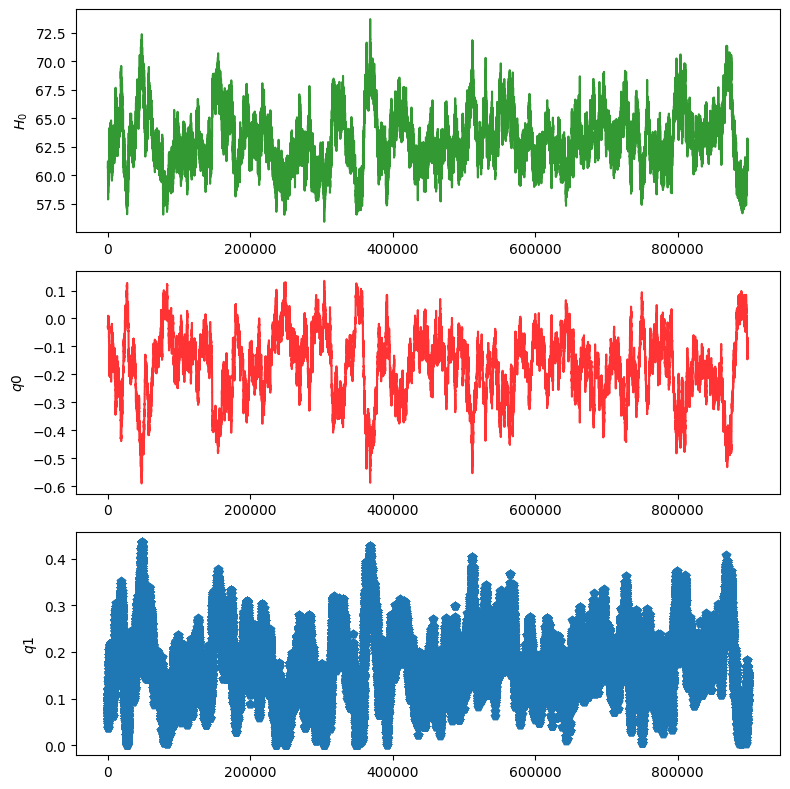

In [ ]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")


# Plot the traceplot of q0
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$q0$")

# Plot the traceplot of q1
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$q1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [ ]:
print("""MCMC result:
    H_0 = {0[0]} +{0[1]} -{0[2]}
    q_0 = {2[0]} +{2[1]} -{2[2]}
    q_1 = {4[0]} +{4[1]} -{4[2]}
""".format(h0_mcmc, h0_ini, q0_mcmc, q0_ini, q1_mcmc, q1_ini))

MCMC result:
    H_0 = 62.87121394343291 +2.8106942178280505 -2.231522491544766
    q_0 = -0.1618127235720773 +0.10803909813520032 -0.1335622107104553
    q_1 = 0.16875804391720992 +0.07843062625051705 -0.06513249060588004



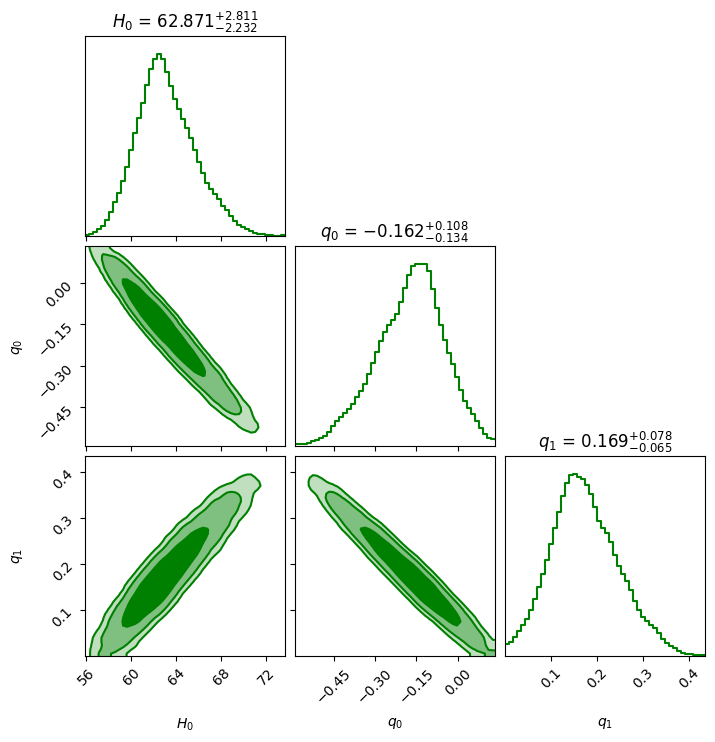

In [ ]:
fig = corner.corner(samples_MH,bins=50,color="g",labels=["$H_0$","$q_0$", "$q_1$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")

In [ ]:
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.1 MB/s eta 0:00:00


Best-fit Parameters:
h0 = 63.414774922661906
q0 = -0.19688564001394343
q1 = 0.1928988566535263


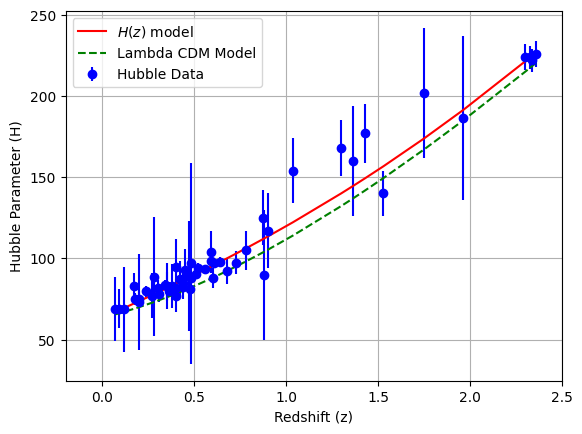

In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_55%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, h0, q0, q1):
    return h0 * (1 + z) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + z**2) - 1))

# Lambda CDM model function
def lambda_cdm(z, hubble_constant):
    omega_m = 0.3  # Example value for matter density parameter in Lambda CDM model
    omega_lambda = 1 - omega_m
    return hubble_constant * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

# Create an lmfit Model object for the hubble_func
model = Model(hubble_func)

# Set initial parameter values for the hubble_func
params = model.make_params(h0=70, q0=0, q1=0)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("q0 =", best_fit_parameters['q0'].value)
print("q1 =", best_fit_parameters['q1'].value)

# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters for hubble_func
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line for hubble_func
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Generate the Lambda CDM predicted values
lambda_cdm_H = lambda_cdm(z, best_fit_parameters['h0'].value)

# Plot the Lambda CDM line
plt.plot(z, lambda_cdm_H, 'g--', label='Lambda CDM Model')

# Add labels and legend
plt.xlim(-0.2,2.5)
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


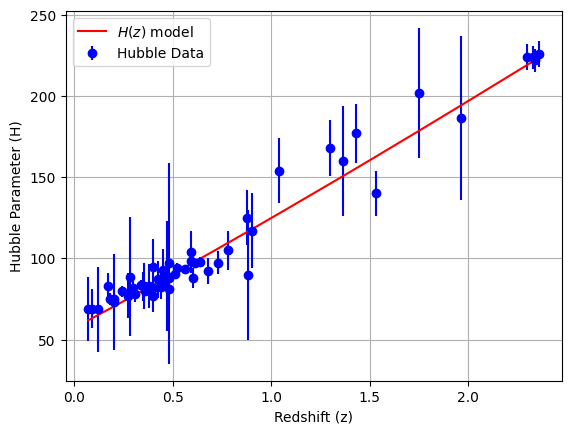

In [ ]:
# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Add labels and legend
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
pip install numpy matplotlib requests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests

# Define the function
def hubble_function(z, h0, q0, q1):
    return h0 * (1 + z) ** (1 + q0) * (1 + z ** 2) ** (q1 / 2)

# Load data from URLs
def load_data(url):
    response = requests.get(url)
    data = response.text.split('\n')
    data = [line.split() for line in data if line]
    data = np.array(data, dtype=float)
    return data[:, 0], data[:, 1]

# Load datasets
z_46, h_46 = load_data('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt')
z_55, h_55 = load_data('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_55%20data%20set.txt')

# Define the parameters for the function
h0 = np.linspace(50, 100, 100)
q0 = np.linspace(-1, 1, 100)
q1 = np.linspace(0, 1, 100)

# Create a grid of parameters
H0, Q0, Q1 = np.meshgrid(h0, q0, q1, indexing='ij')

# Calculate the function values
Z_46, Q0, Q1 = np.meshgrid(z_46, q0, q1, indexing='ij')
Z_55, Q0, Q1 = np.meshgrid(z_55, q0, q1, indexing='ij')

Hubble_46 = hubble_function(Z_46, H0, Q0, Q1)
Hubble_55 = hubble_function(Z_55, H0, Q0, Q1)

# Compute the chi-square values for the two datasets
chi_square_46 = np.sum(((Hubble_46 - h_46[:, None, None])**2) / (0.1 ** 2), axis=0)
chi_square_55 = np.sum(((Hubble_55 - h_55[:, None, None])**2) / (0.1 ** 2), axis=0)

# Plot the contour plot
plt.figure(figsize=(10, 8))
contour_46 = plt.contourf(Q0[0, :, :], Q1[:, 0, :], chi_square_46.T, levels=50, cmap='viridis', norm=LogNorm())
contour_55 = plt.contourf(Q0[0, :, :], Q1[:, 0, :], chi_square_55.T, levels=50, cmap='plasma', norm=LogNorm())
plt.colorbar(contour_46, label=r'$\chi^2$ (Dataset 1)', orientation='vertical')
plt.colorbar(contour_55, label=r'$\chi^2$ (Dataset 2)', orientation='vertical')
plt.xlabel(r'$q_0$')
plt.ylabel(r'$q_1$')
plt.title(r'$\chi^2$ Contour Plot for Hubble Function Parameters')
plt.show()


ValueError: ignored

Best-fit Parameters:
h0 = 63.414774922661906
q0 = -0.19688564001394343
q1 = 0.1928988566535263


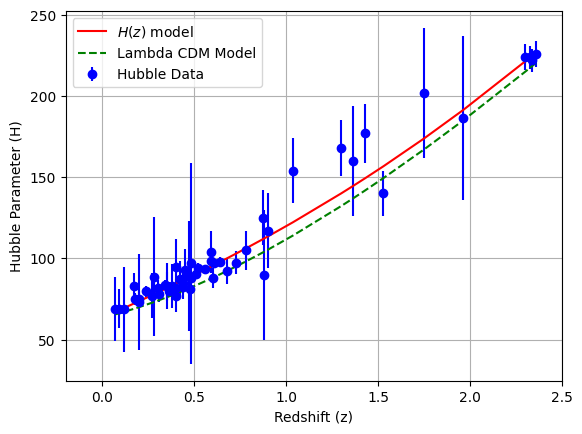

In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_55%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, h0, q0, q1):
    return h0 * (1 + z) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + z**2) - 1))

# Lambda CDM model function
def lambda_cdm(z, hubble_constant):
    omega_m = 0.3  # Example value for matter density parameter in Lambda CDM model
    omega_lambda = 1 - omega_m
    return hubble_constant * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

# Create an lmfit Model object for the hubble_func
model = Model(hubble_func)

# Set initial parameter values for the hubble_func
params = model.make_params(h0=70, q0=0, q1=0)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("q0 =", best_fit_parameters['q0'].value)
print("q1 =", best_fit_parameters['q1'].value)

# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters for hubble_func
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line for hubble_func
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Generate the Lambda CDM predicted values
lambda_cdm_H = lambda_cdm(z, best_fit_parameters['h0'].value)

# Plot the Lambda CDM line
plt.plot(z, lambda_cdm_H, 'g--', label='Lambda CDM Model')

# Add labels and legend
plt.xlim(-0.2,2.5)
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests

# Define the function
def hubble_function(z, h0, q0, q1):
    return h0 * (1 + z) ** (1 + q0) * (1 + z ** 2) ** (q1 / 2)

# Load data from URLs
def load_data(url):
    response = requests.get(url)
    data = response.text.split('\n')
    data = [line.split() for line in data if line]
    data = np.array(data, dtype=float)
    return data[:, 0], data[:, 1]

# Load datasets
z_46, h_46 = load_data('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt')
z_55, h_55 = load_data('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_55%20data%20set.txt')

# Define the parameters for the function
h0 = np.linspace(50, 100, 100)
q0 = np.linspace(-1, 1, 100)
q1 = np.linspace(0, 1, 100)

# Create a grid of parameters
H0, Q0, Q1 = np.meshgrid(h0, q0, q1, indexing='ij')

# Create meshgrid for z values with the correct dimensions
Z_46, Q0, Q1 = np.meshgrid(z_46, q0, q1, indexing='ij')
Z_55, Q0, Q1 = np.meshgrid(z_55, q0, q1, indexing='ij')

# Calculate the function values
Hubble_46 = hubble_function(Z_46, H0, Q0, Q1)
Hubble_55 = hubble_function(Z_55, H0, Q0, Q1)

# Compute the chi-square values for the two datasets
chi_square_46 = np.sum(((Hubble_46 - h_46[:, None, None])**2) / (0.1 ** 2), axis=0)
chi_square_55 = np.sum(((Hubble_55 - h_55[:, None, None])**2) / (0.1 ** 2), axis=0)

# Plot the contour plot
plt.figure(figsize=(10, 8))
contour_46 = plt.contourf(Q0[0, :, :], Q1[:, 0, :], chi_square_46.T, levels=50, cmap='viridis', norm=LogNorm())
contour_55 = plt.contourf(Q0[0, :, :], Q1[:, 0, :], chi_square_55.T, levels=50, cmap='plasma', norm=LogNorm())
plt.colorbar(contour_46, label=r'$\chi^2$ (Dataset 1)', orientation='vertical')
plt.colorbar(contour_55, label=r'$\chi^2$ (Dataset 2)', orientation='vertical')
plt.xlabel(r'$q_0$')
plt.ylabel(r'$q_1$')
plt.title(r'$\chi^2$ Contour Plot for Hubble Function Parameters')
plt.show()

ValueError: ignored

In [69]:
!pip install corner

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [71]:
def load_data(url):
    response = requests.get(url)
    data = np.loadtxt(response.text.splitlines())
    x, y, yerr = data[:, 0], data[:, 1], data[:, 2]
    return x, y, yerr


In [72]:
# URLs for the datasets
urls = [
    'https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt',
    'https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/Bao_26%20data%20set.txt'
]

In [73]:
# Load and process the data from the URLs
hubble_x, hubble_y, hubble_yerr = load_data(urls[0])
bao_x, bao_y, bao_yerr = load_data(urls[1])

In [74]:
#Initial seeds
h0_ini,q0_ini,q1_ini=60,0,0

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    h0, q0, q1 = theta
    model = h0 * (1+x)**(1+q0)* (1+x**2)**(q1/2)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [75]:
#Define Prior Function
def prior(theta):
    h0, q0, q1= theta
    if 50.0< h0 < 100.0 and -3.0 < q0 < 3.0 and 0 < q1 < 4.0:
        return 0.0
    return -np.inf

#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [76]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

initials=h0_ini,q0_ini,q1_ini

In [77]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01, 0.06]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
h0_mcmc, q0_mcmc, q1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 167.647 seconds
----------------------------------------------------------------------



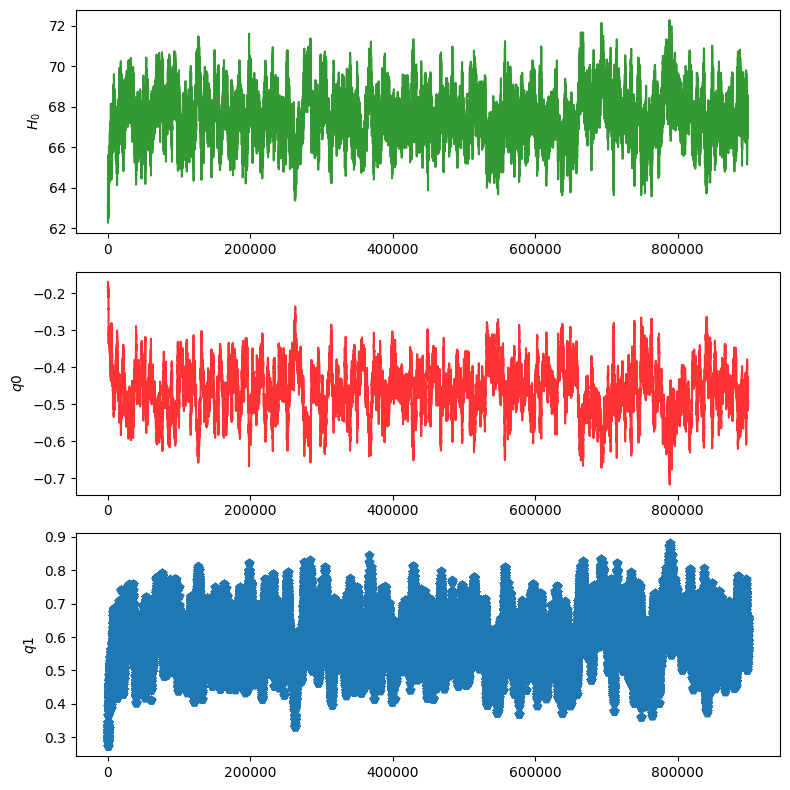

In [78]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")


# Plot the traceplot of q0
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$q0$")

# Plot the traceplot of q1
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$q1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [79]:
print("""MCMC result:
    H0 = {0[0]} +{0[1]} -{0[2]}
    q0 = {2[0]} +{2[1]} -{2[2]}
    q1 = {4[0]} +{4[1]} -{4[2]}
""".format(h0_mcmc, h0_ini, q0_mcmc, q0_ini, q1_mcmc, q1_ini))

MCMC result:
    H0 = 67.4846622463752 +1.2494030087749763 -1.2169161253924585
    q0 = -0.46228613785287975 +0.06774962958246844 -0.0705603131282434
    q1 = 0.5939589612921052 +0.07687915042753013 -0.07260965404201802



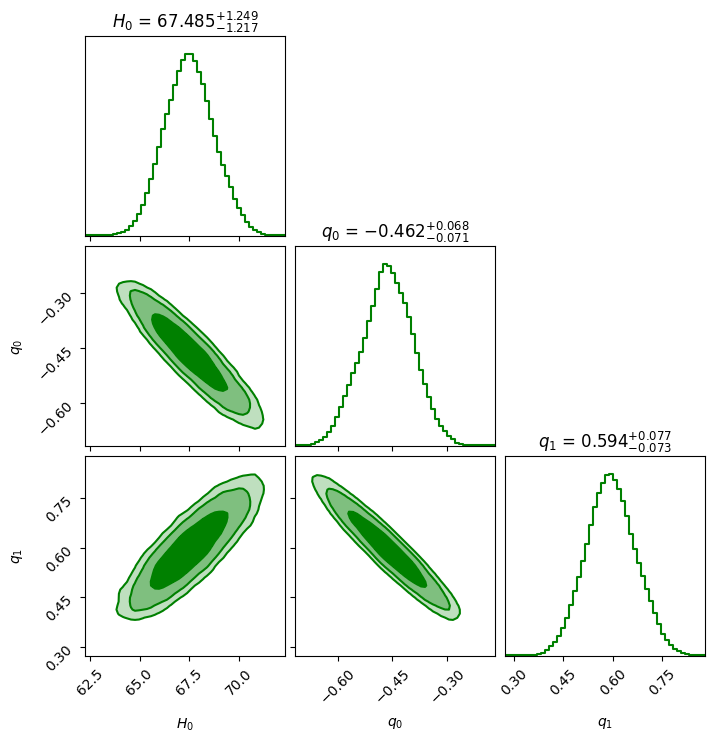

In [80]:
fig = corner.corner(samples_MH,bins=50,color="g",labels=["$H_0$","$q_0$", "$q_1$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")

In [1]:
!pip install corner

In [3]:
! pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 855.3 kB/s eta 0:00:00


In [8]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
# Load the datasets with generic column names
hubble_data = pd.read_csv("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_31%20datas%20set.txt", sep='\s+', header=None, names=['x', 'y', 'yerr'])
bao_data = pd.read_csv("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/Bao_26%20data%20set.txt", sep='\s+', header=None, names=['x', 'y', 'yerr'])

# Print the first few rows of both datasets to inspect the data
print("Hubble Data:")
print(hubble_data.head())
print("Bao Data:")
print(bao_data.head())


Hubble Data:
        x     y  yerr
0  0.0700  69.0  19.6
1  0.0900  69.0  12.0
2  0.1200  68.6  26.2
3  0.1700  83.0   8.0
4  0.1791  75.0   4.0
Bao Data:
      x      y  yerr
0  0.24  79.69  2.99
1  0.30  81.70  6.22
2  0.31  78.18  4.74
3  0.34  83.80  3.66
4  0.35  82.70  9.10


In [37]:
# Concatenate the datasets
combined_data = pd.concat([hubble_data, bao_data], ignore_index=True)

# Extract data
x = combined_data['x'].values.astype(float)
y = combined_data['y'].values.astype(float)
yerr = combined_data['yerr'].values.astype(float)

In [38]:
# Define the function
def model(params, x):
    h0, q0, q1 = params
    return h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))

In [39]:
# Define the log-likelihood function
def log_likelihood(params, x, y, yerr):
    model_values = model(params, x)
    residuals = y - model_values
    return -0.5 * np.sum((residuals / yerr)**2)

In [40]:
# Define the log-prior function (assuming uniform priors)
def log_prior(params):
    h0, q0, q1 = params
    if 0 < h0 < 100 and -10 < q0 < 10 and -10 < q1 < 10:
        return 0.0
    return -np.inf

In [41]:
# Define the log-probability function
def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

In [42]:
# Initial parameter values for the MCMC sampler
initial_params = [60, 0.1, 0.1]

In [43]:
# Number of walkers (chains) and number of steps in the MCMC sampler
nwalkers = 100
nsteps = 5000

In [44]:
# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, len(initial_params), log_probability, args=(x, y, yerr))

In [45]:
# Run the MCMC sampler
sampler.run_mcmc(initial_state=np.random.randn(nwalkers, len(initial_params)), nsteps=nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:21<00:00, 235.52it/s]


State([[ 6.39370542e+01 -1.93262839e-01  2.00747897e-01]
 [ 6.11393182e+01 -1.26978407e-01  1.65862378e-01]
 [ 6.49293103e+01 -2.71489285e-01  2.45245628e-01]
 [ 5.96431668e+01  1.73719876e-02  4.49658117e-02]
 [ 6.46626172e+01 -2.44334694e-01  2.38196844e-01]
 [ 6.25357029e+01 -1.92542020e-01  1.94290417e-01]
 [ 6.04281244e+01 -5.37198474e-02  1.18369566e-01]
 [ 6.38085226e+01 -2.35771131e-01  2.05584200e-01]
 [ 6.24953898e+01 -1.67634222e-01  1.77569859e-01]
 [ 6.24798751e+01 -1.70627766e-01  1.78247799e-01]
 [ 6.22097976e+01 -8.32996792e-02  9.82786067e-02]
 [ 6.61923022e+01 -2.85169671e-01  2.45836388e-01]
 [ 6.32575722e+01 -1.70560528e-01  1.73959564e-01]
 [ 6.72008856e+01 -3.59293725e-01  2.91721069e-01]
 [ 6.28897124e+01 -1.77641290e-01  1.68420389e-01]
 [ 6.37287760e+01 -2.20861164e-01  2.01823223e-01]
 [ 6.00980841e+01 -2.42191280e-02  7.37934021e-02]
 [ 6.07969053e+01 -1.09778003e-01  1.71533204e-01]
 [ 6.21043051e+01 -1.53830267e-01  1.69162462e-01]
 [ 6.71867281e+01 -3.7682

In [46]:
# Get the samples from the MCMC run
samples = sampler.get_chain()

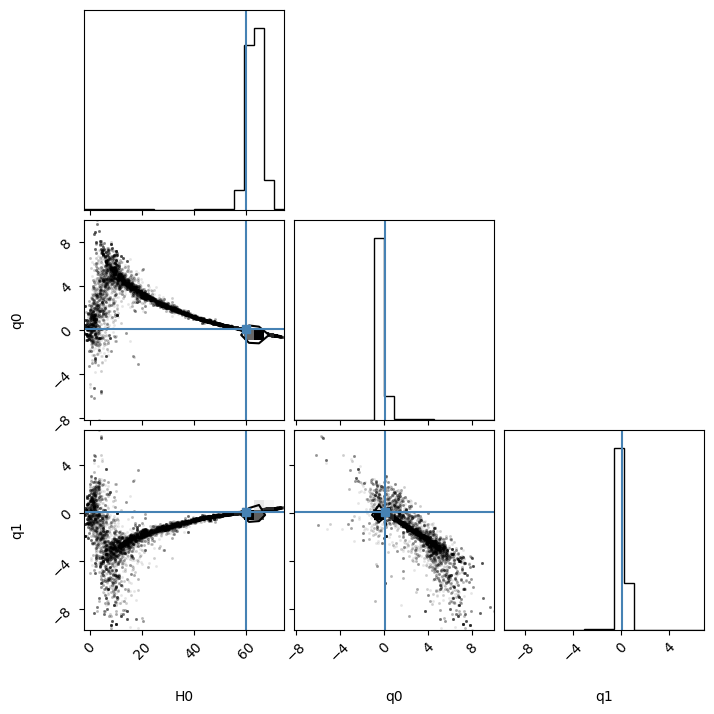

In [47]:
# Create a corner plot
labels = ['H0', 'q0', 'q1']
corner.corner(samples.reshape(-1, len(initial_params)), labels=labels, truths=initial_params)
plt.show()

In [48]:
!pip install corner

In [49]:
! pip install emcee

In [51]:
# Load the datasets with generic column names
hubble_data = pd.read_csv("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt", sep='\s+', header=None, names=['x', 'y', 'yerr'])

# Print the first few rows of both datasets to inspect the data
print("Hubble Data:")
print(hubble_data.head())

Hubble Data:
      x      y  yerr
0  0.00  67.77   1.3
1  0.07  69.00  19.6
2  0.09  69.00  12.0
3  0.01  69.00  12.0
4  0.12  68.60  26.2


In [52]:
# Extract data
x = combined_data['x'].values.astype(float)
y = combined_data['y'].values.astype(float)
yerr = combined_data['yerr'].values.astype(float)

In [53]:
# Define the function
def model(params, x):
    h0, q0, q1 = params
    return h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))

In [54]:
# Define the log-likelihood function
def log_likelihood(params, x, y, yerr):
    model_values = model(params, x)
    residuals = y - model_values
    return -0.5 * np.sum((residuals / yerr)**2)

In [55]:
# Define the log-prior function (assuming uniform priors)
def log_prior(params):
    h0, q0, q1 = params
    if 0 < h0 < 100 and -10 < q0 < 10 and -10 < q1 < 10:
        return 0.0
    return -np.inf

In [56]:
# Define the log-probability function
def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

In [57]:
# Initial parameter values for the MCMC sampler
initial_params = [70, 0, 0]

In [58]:
# Number of walkers (chains) and number of steps in the MCMC sampler
nwalkers = 100
nsteps = 5000

In [59]:
# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, len(initial_params), log_probability, args=(x, y, yerr))

In [60]:
# Run the MCMC sampler
sampler.run_mcmc(initial_state=np.random.randn(nwalkers, len(initial_params)), nsteps=nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:23<00:00, 213.10it/s]


State([[ 6.09031540e+01 -1.13596577e-01  1.59503494e-01]
 [ 5.80655174e+01  7.79064599e-02  2.67697454e-02]
 [ 6.38412676e+01 -2.22768716e-01  2.04741769e-01]
 [ 6.72073515e+01 -3.29330954e-01  2.52246553e-01]
 [ 6.27343147e+01 -2.04367464e-01  2.22847631e-01]
 [ 6.27093241e+01 -1.41981820e-01  1.55671948e-01]
 [ 6.34122248e+01 -1.77058140e-01  1.74393159e-01]
 [ 6.18702937e+01 -1.16182023e-01  1.13665745e-01]
 [ 6.05273882e+01 -3.88176071e-02  9.66936782e-02]
 [ 6.84079631e+01 -3.96845050e-01  3.09739448e-01]
 [ 6.26258036e+01 -1.70274357e-01  1.68708595e-01]
 [ 6.66053037e+01 -3.21398456e-01  2.40275418e-01]
 [ 6.40846195e+01 -1.93449602e-01  1.69295385e-01]
 [ 6.64666725e+01 -3.16955378e-01  2.64872113e-01]
 [ 6.22177805e+01 -1.58713877e-01  1.77239839e-01]
 [ 6.23453935e+01 -1.01784430e-01  1.12267621e-01]
 [ 6.16593894e+01 -9.18528612e-02  1.39236843e-01]
 [ 6.97059209e+01 -4.87254927e-01  3.49669638e-01]
 [ 6.25522998e+01 -1.08668630e-01  1.21471633e-01]
 [ 6.97185945e+01 -4.9520

In [61]:
# Get the samples from the MCMC run
samples = sampler.get_chain()

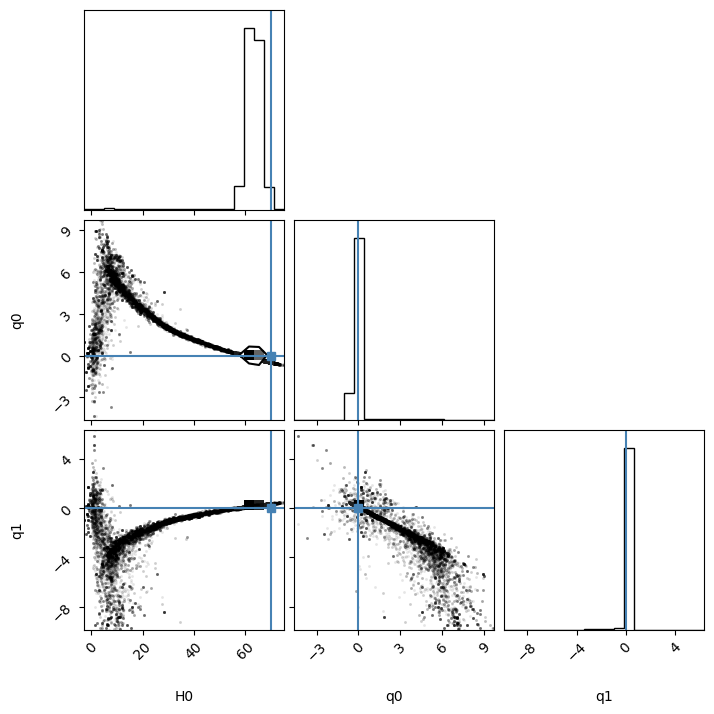

In [62]:
# Create a corner plot
labels = ['H0', 'q0', 'q1']
corner.corner(samples.reshape(-1, len(initial_params)), labels=labels, truths=initial_params)
plt.show()

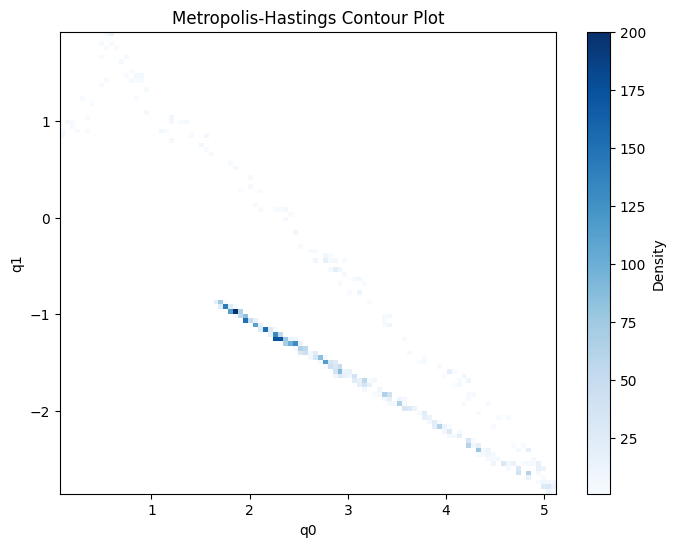

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the datasets
hubble_data = pd.read_csv("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt", sep='\s+', header=None, names=['x', 'y', 'yerr'])
bao_data = pd.read_csv("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/Bao_26%20data%20set.txt", sep='\s+', header=None, names=['x', 'y', 'yerr'])

# Combine the datasets
combined_data = pd.concat([hubble_data, bao_data], ignore_index=True)

# Extract data
x = combined_data['x'].values
y = combined_data['y'].values
yerr = combined_data['yerr'].values

# Define the function to fit
def model(params, x):
    h0, q0, q1 = params
    return h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))

# Define log-likelihood function
def log_likelihood(params, x, y, yerr):
    model_values = model(params, x)
    residuals = y - model_values
    chi_square = np.sum((residuals / yerr) ** 2)
    return -0.5 * chi_square

# Metropolis-Hastings MCMC sampler
def metropolis_hastings(log_likelihood, n_params, n_steps, proposal_std=0.1):
    current_params = np.random.rand(n_params)
    current_log_prob = log_likelihood(current_params, x, y, yerr)
    samples = [current_params]
    for _ in range(n_steps):
        proposed_params = current_params + np.random.normal(0, proposal_std, n_params)
        proposed_log_prob = log_likelihood(proposed_params, x, y, yerr)
        acceptance_ratio = np.exp(proposed_log_prob - current_log_prob)
        if np.random.rand() < acceptance_ratio:
            current_params = proposed_params
            current_log_prob = proposed_log_prob
        samples.append(current_params)
    return np.array(samples)

# Number of MCMC steps
n_steps = 5000

# Run Metropolis-Hastings MCMC
n_params = 3  # Number of parameters in the model
samples = metropolis_hastings(log_likelihood, n_params, n_steps)

# Extracting the individual parameters from samples
h0_samples, q0_samples, q1_samples = samples[:, 0], samples[:, 1], samples[:, 2]

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.hist2d(q0_samples, q1_samples, bins=100, cmap='Blues', cmin=1)
plt.xlabel('q0')
plt.ylabel('q1')
plt.colorbar(label='Density')
plt.title('Metropolis-Hastings Contour Plot')
plt.show()


In [64]:
pip install numpy emcee corner requests


In [65]:
import numpy as np
import requests

# Load the datasets
hubble_response = requests.get("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt")
bao_response = requests.get("https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/Bao_26%20data%20set.txt")

# Process the datasets
def process_data(response):
    data = response.text.split('\n')
    x, y, yerr = [], [], []
    for line in data:
        if line:
            values = line.split()
            x.append(float(values[0]))
            y.append(float(values[1]))
            yerr.append(float(values[2]))
    return np.array(x), np.array(y), np.array(yerr)

hubble_x, hubble_y, hubble_yerr = process_data(hubble_response)
bao_x, bao_y, bao_yerr = process_data(bao_response)


In [66]:
def model(params, x):
    h0, q0, q1 = params
    return h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))

def log_likelihood(params, x, y, yerr):
    model_values = model(params, x)
    residuals = y - model_values
    return -0.5 * np.sum((residuals / yerr)**2)

def log_prior(params):
    h0, q0, q1 = params
    if 0 < h0 < 100 and -10 < q0 < 10 and -10 < q1 < 10:
        return 0.0
    return -np.inf

def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)


In [67]:
import emcee

# Initial parameter values for the MCMC sampler
initial_params = [70, 0, 0]

# Number of walkers (chains) and number of steps in the MCMC sampler
nwalkers = 100
nsteps = 5000

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, len(initial_params), log_probability, args=(hubble_x, hubble_y, hubble_yerr))

# Run the MCMC sampler
sampler.run_mcmc(np.random.randn(nwalkers, len(initial_params)), nsteps=nsteps, progress=True)

# Get the samples from the MCMC run
samples = sampler.get_chain(flat=True)


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:22<00:00, 220.77it/s]


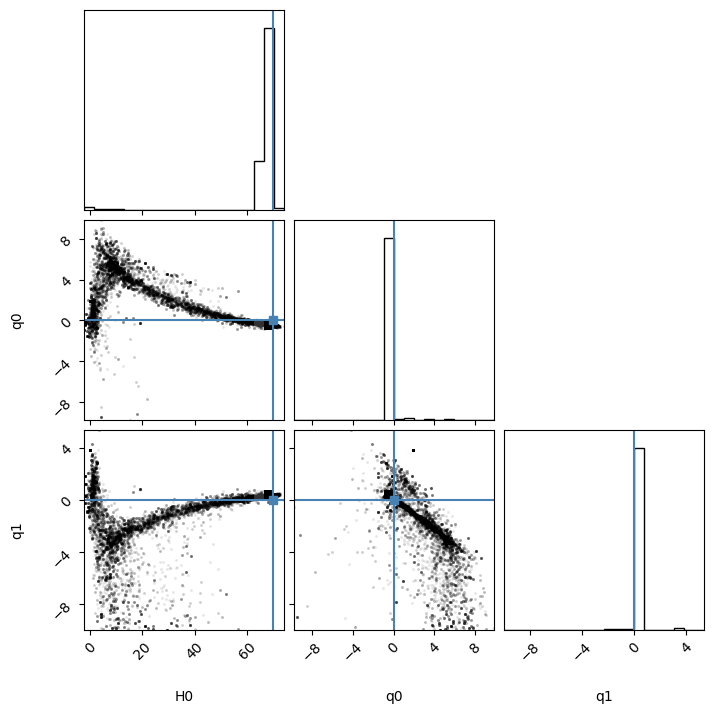

In [68]:
import corner

# Create a corner plot
labels = ['H0', 'q0', 'q1']
corner.corner(samples, labels=labels, truths=initial_params)
plt.show()
